# Using Linear Regression to predict house sale prices

In this project we illustrate how to set-up a machine-learning workflow and test the model. 
We use as an example the price of of house sales in Ames, Iowa. 
We do not aim at building an optimal model: more feature engineering and a better cross-validation procedure would be needed to reach its full potential. 
This notebook should be conceived as a simple first step, which should be refined and combined with oher models to become competitive or useful in real-world examples.

## Setting-up the workflow

In this section we define a general function to help set-up the machine-learning workflow. 
We first import the modules we will need: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

We then define the function `train_and_test` which trains a model and returns the error between its prediction and the true data. 
Its parameters are: 
* `data`: the dataframe used to train and test the model, 
* `target`: the name of the target column, 
* `model`: the model to be trained and tested (by default, a linear regression model), 
* `error_function`: the error function to be used (by default, the root mean squared error divided by the standard deviation of the target), 
* `features`: the list of names of columns to be used as features (by default, all numerical columns except `target`), 
* `n_train`: the number of rows to be used for training (by default, approximately 80% of the dataset), 
* `randomize`: whether the rows of the dataframe should be randomly re-ordered before the separation into training and test sets (by default, `True`),
* `k`: the number of folds if larger than 1 (in which case `n_train` is not used); if 1 or smaller, a simple training / test division is performed.

In [2]:
def train_and_test(data, target, 
                   model = LinearRegression(), 
                   error_function = lambda y1, y2: np.sqrt(mean_squared_error(y1,y2)) / y2.std(), 
                   features = None, 
                   n_train = 0, 
                   randomize = True,
                   k = 0): 
    '''
    Divides data into a training set and a test set, trains the model on the 
        training set, compute its prediction for the test set, and returns the 
        error. 
    
    If features is None, the features are all the numerical columns except 
        target.
    If n_train is 0, the training set contains close to 80% of the rows of data.
    If randomize is True, the rows of data are randomly reschuffled before the
        division into training and test sets. 
    
    data: pandas dataframe
    target: name of a numerical column in data
    model: sklearn model
    error_function: a function taking two series as argument and returning a 
        float
    features: list of names of columns of data or None
    n_train: positive integer or 0
    randomize: bool
    k: integer
    '''
    
    # if randomize is True, randomly re-order the dataset
    if(randomize):
        data = data.sample(frac=1)
    
    # if features is not given, take all the numerical columns except target
    if features is None: 
        features = list(data.select_dtypes(include=[np.number]).columns)
        features.remove(target)
    
    if(k <= 1):
    
        # if n_train is not given, take (approximately) 80% of the data
        if n_train == 0:
            n_train = int(0.8*data.shape[0])

        # features for the training set
        X_train = data[features].iloc[:n_train]

        # target for the training set
        y_train = data[target].iloc[:n_train]

        # features for the test set
        X_test = data[features].iloc[n_train:]

        # target for the test set
        y_test = data[target].iloc[n_train:] 

        # fit the model on the training set
        model.fit(X_train, y_train)

        # compute and return the error function
        return error_function(model.predict(X_test), y_test)
    
    else: 
        
        errors = []
        
        # perform k-fold validation
        kf = KFold(n_splits = k, shuffle = randomize)
        for train_index, test_index, in kf.split(data):
            X_train = data[features].iloc[train_index]
            y_train = data[target].iloc[train_index]
            X_test = data[features].iloc[test_index]
            y_test = data[target].iloc[test_index]
            model.fit(X_train, y_train)
            errors.append(error_function(model.predict(X_test), y_test))
        print(errors)
        print('Mean error: ' + str(np.mean(errors)))

### Description of the dataset

The data we will use, in the file `AmesHousing.txt`, is a [dataset on house sales in Ames from 2006 to 2010](http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls). 
It was compiled by Dean De Cock from Truman State University and is described in details in [this article of the Journal of Statistics Education](https://doi.org/10.1080/10691898.2011.11889627). 
The documentation is available [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).
It contains, according to the article, 80 columns related to house sales, among which are 20 continuous variables, 14 are discrete ones, 23 are ordinal ones, and 23 are cardinal ones.

Let us import it, check the number of columns, and print the first few lines:

In [3]:
df = pd.read_csv('../Data/AmesHousing/AmesHousing.txt', delimiter = '\t')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


It seems there are actually 82 columns. 
The reason for this difference is probably that the columns `Order` (which does not give information on the actual sale) and `SalePrice` (which will be the target) were not included in the count mentioned in the article.
Let us now determine the number of lines and see if there are missing values:

In [4]:
print('Number of lines: ' + str(df.shape[0]))
print()
print('Missing values:')
df.isnull().sum().sort_values(ascending=False)[:30]

Number of lines: 2930

Missing values:


Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Cond           80
Bsmt Qual           80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Electrical           1
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
dtype: int64

The dataframe has 2930 lines. 
27 columns among the 82 have at least one missing value. 
Among them, 5 have more than half of their values missing.

## Feature Engineering

### Missing values

Let us first deal with the columns having many missing values. 
We start with `Pool QC` (the pool quality), which has the largest number of them. 
Let us see which values it contains. 

In [5]:
df['Pool QC'].value_counts()

Ex    4
Gd    4
TA    3
Fa    2
Name: Pool QC, dtype: int64

Comparing this with the documenttaion, it seems that missing values correspond to `NA`, *i.e.*, no pool. 
Let us thus replace the missing values by the string `NA`:

In [6]:
df['Pool QC'] = df['Pool QC'].fillna('NA')
df['Pool QC'].value_counts()

NA    2917
Ex       4
Gd       4
TA       3
Fa       2
Name: Pool QC, dtype: int64

According to the documentation, the same is true for the columns `Misc Feature`, `Alley`, `Fence`, `Fireplace Qu`, `Garage Qual`, `Garage Cond`, `Garage Finish`, `Garage Type`, `Bsmt Exposure`, `BsmtFin Type 2`, `BsmtFin Type 1`, `Bsmt Cond`, `Bsmt Qual`, and `Mas Vnr Type`: a value `NA` indicates the absence of the thing. 
There are, however, a few apparent inconsistencies. 
First, some values are not missing in `Garage Type` but are missing in other columns related to garages. 
Let us print the relevant columns for these rows:

In [7]:
cols_garage = ['Garage Type', 'Garage Qual', 'Garage Yr Blt', 'Garage Cond', 'Garage Finish']
df[(df['Garage Type'].isnull() == False) & (df['Garage Qual'].isnull())][cols_garage]

,Garage Type,Garage Qual,Garage Yr Blt,Garage Cond,Garage Finish
1356,Detchd,NaN,NaN,NaN,NaN
2236,Detchd,NaN,NaN,NaN,NaN


Both rows have detached garages; but they do not seem to have any peculiarity. 
Since we do not know whether the inconsistency is the information in `Garage Type` or the missing information in the other columns, let us remove these two rows:

In [8]:
df.drop(df[(df['Garage Type'].isnull() == False) & (df['Garage Qual'].isnull())].index, inplace=True)

Similarly, the column `Bsmt Exposure` has more missing values than the other columns refering to basements. 

In [9]:
bsmt_cols = ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Cond', 'Bsmt Qual']
df[(df['Bsmt Exposure'].isnull()) & (df['Bsmt Qual'].isnull() == False)][bsmt_cols]

,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Bsmt Cond,Bsmt Qual
66,NaN,Unf,Unf,TA,Gd
1796,NaN,Unf,Unf,TA,Gd
2779,NaN,Unf,Unf,TA,Gd


There is also one row with a missing value in `BsmtFin Type 2` but not in the other columns relating to basement:

In [10]:
df[(df['BsmtFin Type 2'].isnull()) & (df['Bsmt Qual'].isnull() == False)][bsmt_cols]

,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Bsmt Cond,Bsmt Qual
444,No,GLQ,NaN,TA,Gd


Since we do not know where the errors come from, let us delete these four rows:

In [11]:
df.drop(df[(df['Bsmt Exposure'].isnull()) & (df['Bsmt Qual'].isnull() == False)].index, inplace=True)
df.drop(df[(df['BsmtFin Type 2'].isnull()) & (df['Bsmt Qual'].isnull() == False)].index, inplace=True)

Let us now fill the missing values in the columns `Misc Feature`, `Alley`, `Fence`, `Fireplace Qu`, `Garage Qual`, `Garage Cond`, `Garage Finish`, `Garage Type`, `Bsmt Exposure`, `BsmtFin Type 2`, `BsmtFin Type 1`, `Bsmt Cond`, `Bsmt Qual`, and `Mas Vnr Type` with the string `NA`: 

In [12]:
cols_to_fill = ['Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Garage Qual', 'Garage Cond', 
                'Garage Finish', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Cond', 
                'Bsmt Qual', 'Mas Vnr Type']

for col in cols_to_fill:
    df[col] = df[col].fillna('NA')
    
print('Missing values:')
df.isnull().sum().sort_values(ascending=False)[:11]

Missing values:


Lot Frontage      490
Garage Yr Blt     157
Mas Vnr Area       23
Bsmt Half Bath      2
Bsmt Full Bath      2
Bsmt Unf SF         1
Electrical          1
BsmtFin SF 2        1
BsmtFin SF 1        1
Total Bsmt SF       1
Bsmt Exposure       0
dtype: int64

We have already significantly reduced the number of missing values. 
Let us now deal with the column `Lot Frontage`, giving the number of feet of street connected to the property. 
Since it contains more than 10% of missing values and it is not clear from the documentation how they should be interpreted, making a guess could introduce a significant bias in the data. 
We thus decide to remove this column. 

We also remove the column `Garage Yr Blt`, as it is not clear how a value could be assigned for properties which do not have a garage. 

In [13]:
df = df.drop(['Lot Frontage', 'Garage Yr Blt'], axis=1)

Let us now focus on the rows having a missign value for the column `Mas Vnr Area `: 

In [14]:
df[df['Mas Vnr Area'].isnull()]['Mas Vnr Type']

55      NA
484     NA
517     NA
538     NA
867     NA
1095    NA
1119    NA
1122    NA
1127    NA
1184    NA
1454    NA
1727    NA
1751    NA
1783    NA
1799    NA
1839    NA
1840    NA
2229    NA
2260    NA
2382    NA
2392    NA
2455    NA
2823    NA
Name: Mas Vnr Type, dtype: object

These rows correspond to properties having no masonry veneer. 
We can thus set `Mas Vnr Area` to 0:

In [15]:
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0.)
df.isnull().sum().sort_values(ascending=False)[:8]

Bsmt Full Bath    2
Bsmt Half Bath    2
Electrical        1
Bsmt Unf SF       1
Total Bsmt SF     1
BsmtFin SF 1      1
BsmtFin SF 2      1
BsmtFin Type 1    0
dtype: int64

The majority of the remaining missing values concern basements. 
Let us look at the corresponding rows: 

In [16]:
df[(df['Bsmt Full Bath'].isnull()) | (df['Bsmt Half Bath'].isnull()) | (df['Bsmt Unf SF'].isnull()) | 
   (df['Total Bsmt SF'].isnull()) | (df['BsmtFin SF 1'].isnull()) | (df['BsmtFin SF 2'].isnull())][bsmt_cols]

,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Bsmt Cond,Bsmt Qual
1341,NA,NA,NA,NA,NA
1497,NA,NA,NA,NA,NA


They correspond to two properties having no basement. 
We can thus set the corresponding values to 0: 

In [17]:
cols_to_fill = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'Total Bsmt SF', 
                'BsmtFin SF 1', 'BsmtFin SF 2']

for col in cols_to_fill:
    df[col].fillna(0., inplace=True)

df.isnull().sum().sort_values(ascending=False)[:2]

Electrical    1
SalePrice     0
dtype: int64

There remains only one missing value. 
Let us delete the corresponding row.

In [18]:
df.drop(df[df['Electrical'].isnull()].index, inplace=True)
df.isnull().sum().sort_values(ascending=False)[:1]

SalePrice    0
dtype: int64

### Dealing with years

The two columns `Year Built` and `Year Remod/Add` are not very useful in themselves. 
What is more relevant than the years a property was built, for instance, is how old it were it was when it was sold. 
Let us thus replace these two columns by `Years_Built_Sold` and `Years_Remod_Sold`, giving the numbers of years between these events and the selling date:

In [19]:
df['Years_Built_Sold'] = df['Yr Sold'] - df['Year Built']
df['Years_Remod_Sold'] = df['Yr Sold'] - df['Year Remod/Add']
df.drop(['Year Built', 'Year Remod/Add'], axis=1, inplace=True)

### Dropping the columns which leak information on the sale

We now drop the columns which leak information on the sale. 
There are 4 of them: `Mo Sold`, `Yr Sold`, `Sale Type`, and `Sale Condition`.

In [20]:
leaky_cols = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition']

df.drop(leaky_cols, axis=1, inplace=True)

### Dropping useless columns

Let us also drop the columns `PID`, which we will not use, and `Electrical`, as it is unclear how to treat the properties with a mixed electrical system.

In [21]:
useless_cols = ['PID', 'Electrical']

df.drop(useless_cols, axis=1, inplace=True)

### Nominal columns

Let us replace each nominal column by a set of dummy columns:

In [22]:
nominal_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                'Condition 1', 'Condition 2', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
                'Exterior 2nd', 'Mas Vnr Type', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 
                'Neighborhood']

df_dummies_list = []
for col in nominal_cols: 
    df_dummies = pd.get_dummies(df[col])
    df_dummies.columns = [col + '_' + str(name_col_dum) for name_col_dum in df_dummies.columns]
    df_dummies_list.append(df_dummies)
    
df = pd.concat([df] + df_dummies_list, axis=1, sort=False)

for col in nominal_cols: 
    df.drop(col, axis=1, inplace=True)

### Ordinal columns

We define the function `ordinal_to_float` taking a dataframe, a column name, and a list containing the possible values in ascending order, and replacing this column by numerical values.

In [23]:
def ordinal_to_float(df, col, order): 
    '''
    Replaces the entries of the column col in df by floats from 0. to the 
    number of different entries minus 1. 
    
    df: dataframe
    col: name of a column of df
    order: list of possible values in ascending order
    '''
    replacements = {order[i]: float(i) for i in range(len(order))}
    df[col] = df[col].replace(replacements)

Let us apply it to all ordinal columns with an `object` type (for a linear regression, it does not matter whether the labels are inputted in ascending or descending order):

In [24]:
ordinal_to_float(df, 'Lot Shape', ['Reg', 'IR1', 'IR2', 'IR3'])
ordinal_to_float(df, 'Utilities', ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'])
ordinal_to_float(df, 'Land Slope', ['Gtl', 'Mod', 'Sev'])
ordinal_to_float(df, 'Exter Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Exter Cond', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Bsmt Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Bsmt Cond', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Bsmt Exposure', ['Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'BsmtFin Type 1', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'])
ordinal_to_float(df, 'BsmtFin Type 2', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'])
ordinal_to_float(df, 'Heating QC', ['Ex', 'Gd', 'TA', 'Fa', 'Po'])
ordinal_to_float(df, 'Kitchen Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po'])
ordinal_to_float(df, 'Functional', ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'])
ordinal_to_float(df, 'Fireplace Qu', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Garage Finish', ['Fin', 'RFn', 'Unf', 'NA'])
ordinal_to_float(df, 'Garage Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Garage Cond', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
ordinal_to_float(df, 'Paved Drive', ['Y', 'P', 'N'])
ordinal_to_float(df, 'Pool QC', ['Ex', 'Gd', 'TA', 'Fa', 'NA'])
ordinal_to_float(df, 'Fence', ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'])

### Choice of features

To determine which features to include in the linear regression, let us first compute correlations of each feature with the sale price and show the 20 features with the highest correlation coefficient:

In [25]:
# starting from 1 to exclude the column SalePrice
np.abs(df.corr()['SalePrice']).sort_values(ascending=False)[1:21]
twenty_highest_cor = np.abs(df.corr()['SalePrice']).sort_values(ascending=False)[1:21]
print(twenty_highest_cor)
best_features = list(twenty_highest_cor.index)

Overall Qual            0.799474
Gr Liv Area             0.707241
Exter Qual              0.697913
Kitchen Qual            0.673104
Garage Cars             0.647719
Garage Area             0.640200
Total Bsmt SF           0.633529
1st Flr SF              0.621869
Bsmt Qual               0.607609
Years_Built_Sold        0.559176
Garage Finish           0.550653
Full Bath               0.546139
Years_Remod_Sold        0.535058
Fireplace Qu            0.533855
Mas Vnr Area            0.501961
TotRms AbvGrd           0.495698
Fireplaces              0.474578
Heating QC              0.450192
BsmtFin SF 1            0.433406
Neighborhood_NridgHt    0.432951
Name: SalePrice, dtype: float64


Let us also plot a correlation map of these 20 features to see if there are correlations aong them. 
To help visualization, we show the absolute values of the correlation coefficients.

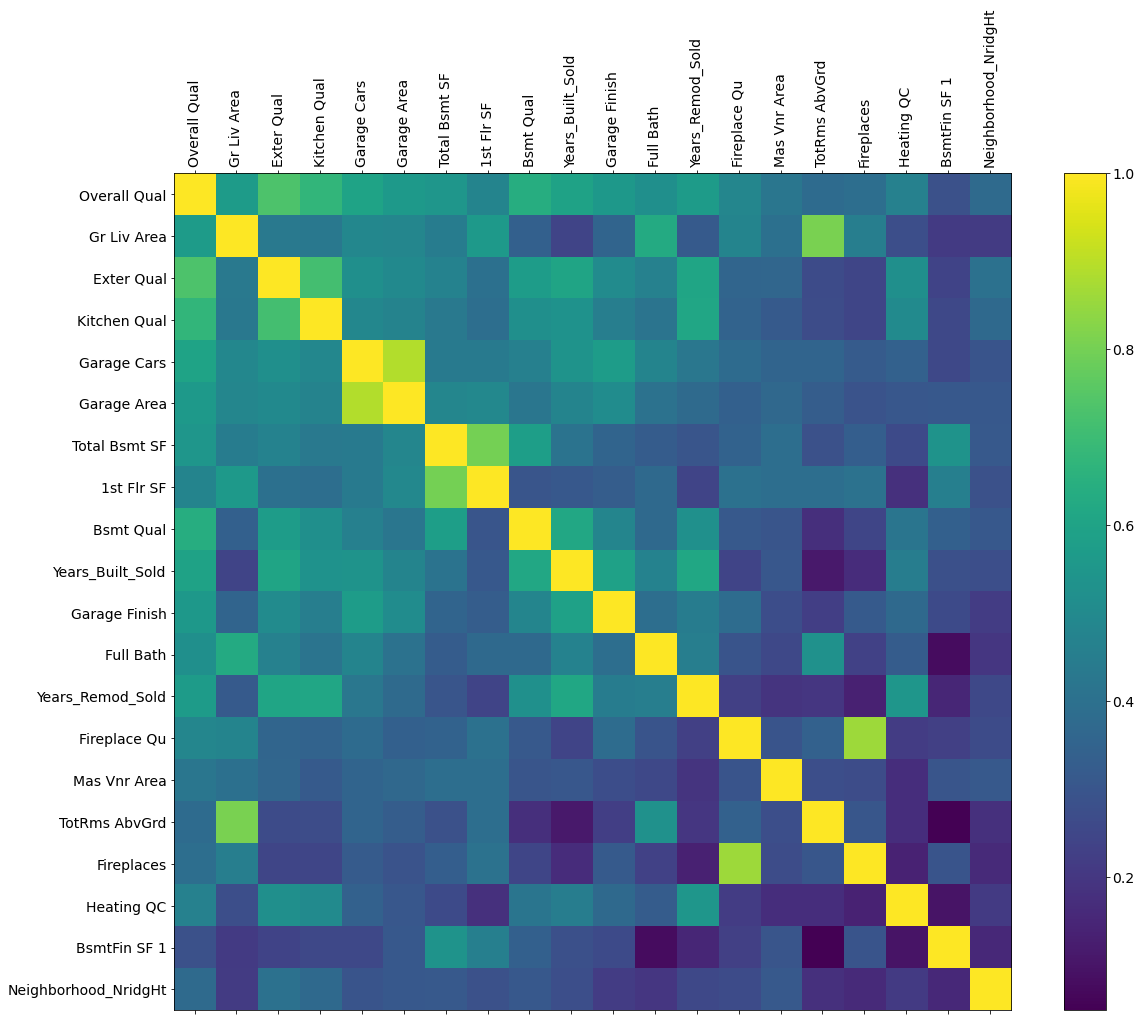

In [26]:
df_t = df[best_features]

f = plt.figure(figsize=(19, 15))
plt.matshow(np.abs(df_t.corr()), fignum=f.number)
plt.xticks(range(df_t.shape[1]), df_t.columns, fontsize=14, rotation=90)
plt.yticks(range(df_t.shape[1]), df_t.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

There seems to be some high correlations. 
To see this more precisely, let us define the function `corr_higher_than` taking a threshold between 0 and 1 and showing where correlations are larger than this value.

In [27]:
def corr_higher_than(threshold):
    f = plt.figure(figsize=(19, 15))
    plt.matshow((np.abs(df_t.corr()) > threshold).astype(int), fignum=f.number)
    plt.xticks(range(df_t.shape[1]), df_t.columns, fontsize=14, rotation=90)
    plt.yticks(range(df_t.shape[1]), df_t.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()

Let us see which couples of features have correlations coefficients higher than 0.6:

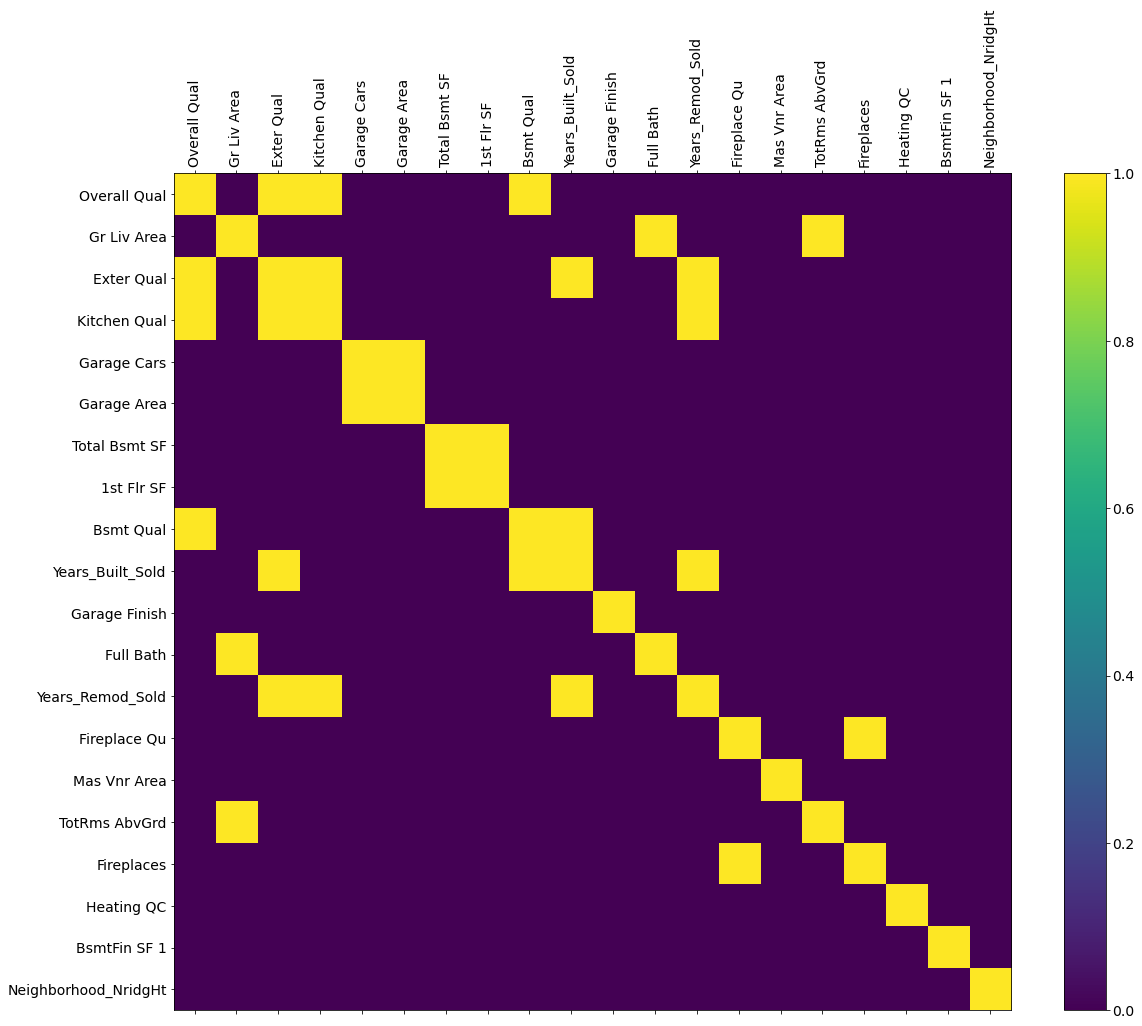

In [28]:
corr_higher_than(0.6)

We remove one feature from each couple of different features with a correlation coefficient higher (in absolute value) than 0.6 to avoid counting the same information twice, aiming to keep the one which is more general or gives more precise information. 
We thus remove the columns `Kitchen Qual`, `Bsmt Qual`, `Full Bath`, `TotRms AbvGrd`, `Years_Remod_Sold`, `Garage Cars`, `1st Floor SF`, and `Fireplace Qu`.

In [29]:
for col in ['Kitchen Qual', 'Bsmt Qual', 'Full Bath', 'TotRms AbvGrd', 'Years_Remod_Sold', 'Garage Cars', '1st Flr SF', 'Fireplace Qu']:
    best_features.remove(col)

Keep only these features and the target:

In [30]:
df = df[best_features + ['SalePrice']]

### Function performing the same transformations

To apply the model we will train to new data, we will need to apply the same transformations to it. 
Let us define the function `transform_features` taking one dataframe as argument and returning the transformed one.

In [31]:
def transform_features(df_init):
    
    # copy the dataframe so that the original one is unmodified
    df = df_init.copy() 
    
    # delete rows 
    df.drop(df[(df['Garage Type'].isnull() == False) & (df['Garage Qual'].isnull())].index, inplace=True)
    df.drop(df[(df['Bsmt Exposure'].isnull()) & (df['Bsmt Qual'].isnull() == False)].index, inplace=True)
    df.drop(df[(df['BsmtFin Type 2'].isnull()) & (df['Bsmt Qual'].isnull() == False)].index, inplace=True)
    df.drop(df[df['Electrical'].isnull()].index, inplace=True)
    
    # fill missing values with the string 'NA'
    cols_to_fill = ['Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Garage Qual', 'Garage Cond', 
                'Garage Finish', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Cond', 
                'Bsmt Qual', 'Mas Vnr Type']
    for col in cols_to_fill:
        df[col] = df[col].fillna('NA')
    
    # set missing values to 0
    cols_to_fill = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'Total Bsmt SF', 
                'BsmtFin SF 1', 'BsmtFin SF 2', 'Mas Vnr Area']
    for col in cols_to_fill:
        df[col].fillna(0., inplace=True)
        
    # dealing with years
    df['Years_Built_Sold'] = df['Yr Sold'] - df['Year Built']
    df['Years_Remod_Sold'] = df['Yr Sold'] - df['Year Remod/Add']
    df.drop(['Year Built', 'Year Remod/Add'], axis=1, inplace=True)
    
    
    # replace nominal columns by dummies
    nominal_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
                'Condition 1', 'Condition 2', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
                'Exterior 2nd', 'Mas Vnr Type', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 
                'Neighborhood']
    df_dummies_list = []
    for col in nominal_cols: 
        df_dummies = pd.get_dummies(df[col])
        df_dummies.columns = [col + '_' + str(name_col_dum) for name_col_dum in df_dummies.columns]
        df_dummies_list.append(df_dummies)
    df = pd.concat([df] + df_dummies_list, axis=1, sort=False)
    for col in nominal_cols: 
        df.drop(col, axis=1, inplace=True)
    
    # convert strings in ordinal columns to floats
    ordinal_to_float(df, 'Lot Shape', ['Reg', 'IR1', 'IR2', 'IR3'])
    ordinal_to_float(df, 'Utilities', ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'])
    ordinal_to_float(df, 'Land Slope', ['Gtl', 'Mod', 'Sev'])
    ordinal_to_float(df, 'Exter Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Exter Cond', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Bsmt Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Bsmt Cond', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Bsmt Exposure', ['Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'BsmtFin Type 1', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'])
    ordinal_to_float(df, 'BsmtFin Type 2', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'])
    ordinal_to_float(df, 'Heating QC', ['Ex', 'Gd', 'TA', 'Fa', 'Po'])
    ordinal_to_float(df, 'Kitchen Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po'])
    ordinal_to_float(df, 'Functional', ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'])
    ordinal_to_float(df, 'Fireplace Qu', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Garage Finish', ['Fin', 'RFn', 'Unf', 'NA'])
    ordinal_to_float(df, 'Garage Qual', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Garage Cond', ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'])
    ordinal_to_float(df, 'Paved Drive', ['Y', 'P', 'N'])
    ordinal_to_float(df, 'Pool QC', ['Ex', 'Gd', 'TA', 'Fa', 'NA'])
    ordinal_to_float(df, 'Fence', ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'])
    
    # feature selection
    df = df[best_features + ['SalePrice']]
    
    return df

## Training and testing the model

Let us now test the model. 
To check that the whole process is working, we reload `df` and apply the function `transform_features` before training the model.

In [32]:
df = pd.read_csv('../Data/AmesHousing/AmesHousing.txt', delimiter = '\t')
df = transform_features(df)

print('\nSimple training/test division:')
print(train_and_test(df, 'SalePrice'))
print('\n5-fold cross-validation:')
train_and_test(df, 'SalePrice', k=5)


Simple training/test division:
0.3792491257622815

5-fold cross-validation:
[0.46410081468910563, 0.5234766992763096, 0.38363591105991723, 0.36960854772467033, 0.3737441936770877]
Mean error: 0.4229132332854181


The mean squared error is typically close to 40% of the standard deviation of the target. 
This linear model thus captures some aspects of what determines the price of a house, although it is by no means perfect.

Let us now try with a k-nearest neighbours model, for k equal to 3, 5, 8, 11, and 14:

In [33]:
# numbers of neighbours to try
values_n_neighbors = [3, 5, 8, 11, 14]

for n_neighbors in values_n_neighbors:
    print('\n\n' + str(n_neighbors) + ' neighbours:')
    print('\nSimple training/test division:')
    print(train_and_test(df, 'SalePrice', model=KNeighborsRegressor(n_neighbors=n_neighbors)))
    print('\n5-fold cross-validation:')
    train_and_test(df, 'SalePrice', k=5, model=KNeighborsRegressor(n_neighbors=n_neighbors))



3 neighbours:

Simple training/test division:
0.5203737313518655

5-fold cross-validation:
[0.48983482354920943, 0.5757117471344496, 0.4657995352438386, 0.46564572385480907, 0.44886664394797127]
Mean error: 0.4891716947460556


5 neighbours:

Simple training/test division:
0.48458493208381637

5-fold cross-validation:
[0.5828080335110661, 0.4377115202189509, 0.4481530472214948, 0.5310559825871842, 0.43262008412029923]
Mean error: 0.48646973353179906


8 neighbours:

Simple training/test division:
0.5032871370847056

5-fold cross-validation:
[0.47295401487455085, 0.46203641336304185, 0.48888877184517343, 0.44514055415441184, 0.4687608703368988]
Mean error: 0.46755612491481535


11 neighbours:

Simple training/test division:
0.49048959471965614

5-fold cross-validation:
[0.4781143202038248, 0.4617879266786233, 0.45687463257250766, 0.48119399803704815, 0.47576053882801833]
Mean error: 0.4707462832640045


14 neighbours:

Simple training/test division:
0.40312217730706856

5-fold cross-v

The optimal number of neighbours seems to be 11. 
The model then gives results which are close t, but a bit worse than, the linear regressor.